# CT Reconstruction

In this exercise we will play with some of the mechanics of how CT scanner generates images. So far in the videos we have talked about the "Tomography" part. Now let's take a closer look at the computation. In this notebook we have some sample code that will load a real CT image and will go through the steps similar to the ones a scanner is going through to do the computation. 

You will see snippets of code in this notebook and some snippets will have comments that start with the word _TASK_. These are yours to fill - read task description and write code that completes the snippet.

## Sinograms

Each time a detector is taking an image, it is computing the amount of photons passing through the body. Since we don't have access to a real scanner, let's simulate this by passing a bunch of rays through a phantom image.

> _Phantoms_ are commonly used in medical imaging. The word may refer to physically-accurate phantoms which are used by medical physicists to calibrate scanners and other devices, and images of phantoms, which could be synthetic 2D or 3D images used to calibrate and test medical software. Take a look at this adorable fetus phantom:  
> <img src="Exercise. CT backprojection.img/baby_phantom.jpg" width="300" align="left">



### Loading image and computing a single projection

In [1]:
# Our human body will be represented by a jpeg image, so we will use PIL library to load and manipulate it

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as nd

im = Image.open("phantom.bmp").convert("L")
print(im)

<PIL.Image.Image image mode=L size=200x200 at 0x11665EB10>


Let us visualize the image here. As you can see it's a few grayscale geometric figures, quite typical for phantoms

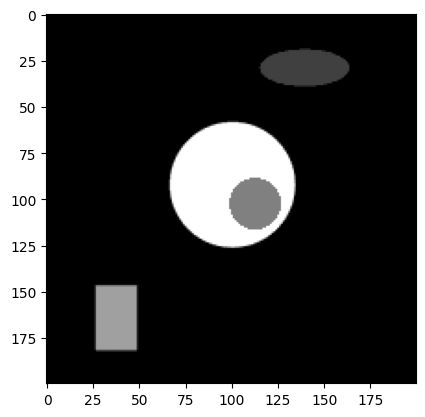

In [2]:
plt.imshow(im, cmap="gray")

Let us compute a projection now. For the sake of simlicity we are assuming that our xrays are following from left to right, all rays are parallel, passing through the entire image. Note that we are just summing all values of pixels that rays meet along the path. In real world the ray would be attenuated by the tissues, and the intensity (or the amount of photons) is decreased as the ray passess through matter, this the detector is effectively subtracting the measured value from a known maximum value. Again, for the sake of simplicity we will do the inverse here - just add everything up.

In [3]:
projection = []
m = np.array(im)
for x in range(0, im.width):
    projection.append(np.sum(m[x]))
        

And let's visualize it by plotting the accumulated intensities encountered along each ray. Effectively, this is a 1-dimensional "x-ray" of our thin slice.

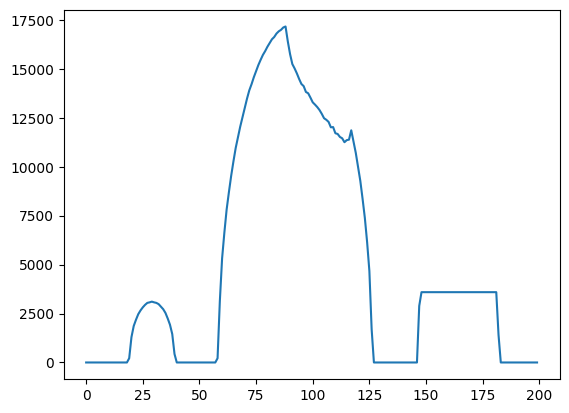

In [4]:
plt.plot(projection)

### Rotate and project again

Now let's simulate rotation of our xray tube/detector gantry and compute another projection

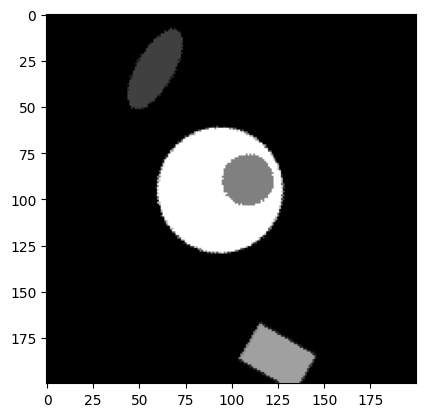

In [5]:
im_r = im.rotate(60)
plt.imshow(im_r, cmap="gray")

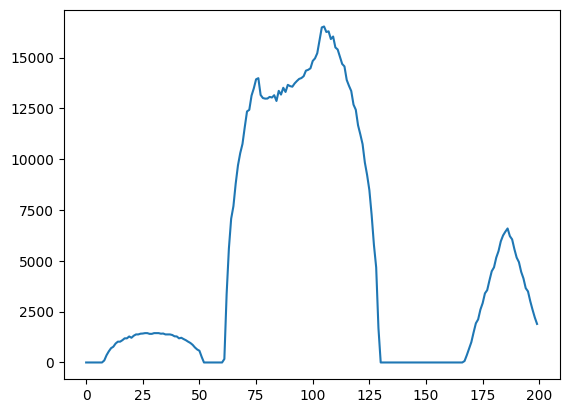

In [6]:
projection = []
m = np.array(im_r)
for x in range(0, im_r.width):
    projection.append(np.sum(m[x]))
plt.plot(projection)

In [9]:
# TASK: Can you see the "tooth" pattern on the rectangle projection on the right? Where is it coming from, what do you think? 
# NOTE: You don't need to write code, just type your answer here

## <The tooth pattern is coming from the fact that the image has been rotated such that the max value is 
# the diagonal of the rectangle, and the projection is summing up the pixel values along the x-axis.>

### Computing the Sinogram

Now, let's assume that our scanner is doing a full 180° rotation, sampling a projection every 3 degrees. What you will end up is a collection of projections (1D "X-ray" images) from every angle. Let's store projections in a list of tuples so that we keep track of what angle was used to compute a projection.

In [10]:
projections = []
for angle in range(0, 180, 3):
    p = []
    im_r = im.rotate(angle)
    for x in range(0, im.width):
        p.append(np.sum(np.array(im_r)[x]))
    projections.append((angle, p))

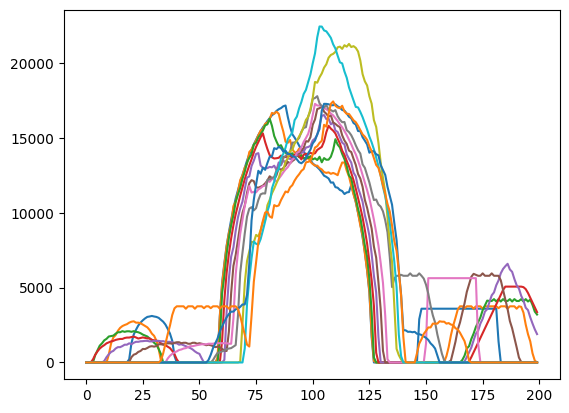

In [12]:
# TASK: can you visualize projections from several interesting angles (like all angles divisible by 15)?

## <Yes, we can visualize projections from angles divisible by 15.>
for angle, p in projections:
    if angle % 15 == 0:
        plt.plot(p, label=f"Angle {angle}°")

In [ ]:
le by 15)?

## <Yes, we can visualize projections from angles divisible by 15.>
for angle, p in projections:
    if angle % 15 == 0:
        plt.plot(p, label=f"Angle {angle}°")

At this point our `projections` variable contains a collection of all projections. Effectively, this is what we get once our measurements are done. Let's plot all projections stacked together as a single image:

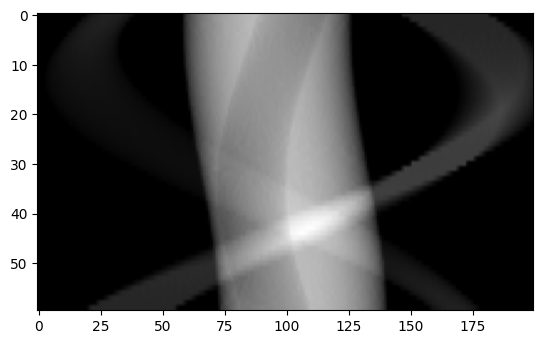

In [13]:
sinogram = np.stack([p[1] for p in projections])
plt.imshow(sinogram, cmap="gray", aspect = 2)

Pretty, isn't it? This image is commonly called _a sinogram_ because it appears to be an overlapping of sinusoids (and there is some neat signal processing math explaining why that is the case), and sometimes people talk of sinogram as the raw data that comes into a CT scanner after the analog signal has been sampled.

But how do we get an image out of this?

Remember, that "C" in "CT" stands for _Computed_ and that's where computation comes in. 

The basic computation is quite simple. We take each projection and "smear" all the aggregated intensity values that have been captured by it across a reconstructed image. Let's do this for one of those projections:

In [14]:
bp = np.zeros((im.width, im.height))

for y in range(sinogram.shape[1]):
    bp[:, y] = projections[0][1]

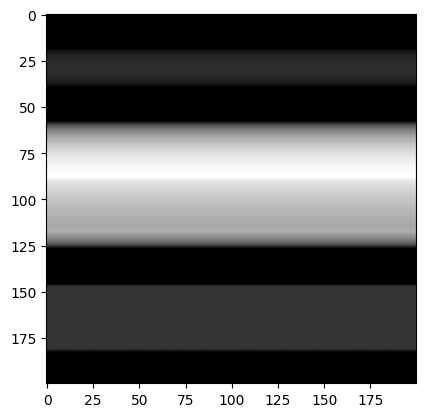

In [15]:
plt.imshow(bp, cmap="gray")

From here, we do this for all other projections, and then stack them all together, remembering the angle from which the projection was taken!

In [16]:
bp = np.zeros((im.width, im.height))

for p in projections:
    
    # Smear the projection
    img = np.zeros(bp.shape)
    for y in range(img.shape[1]):
        img[:, y] = p[1]
        
    # Rotate the projection back
    img = nd.rotate(img, -p[0], reshape = False)
    
    bp += img

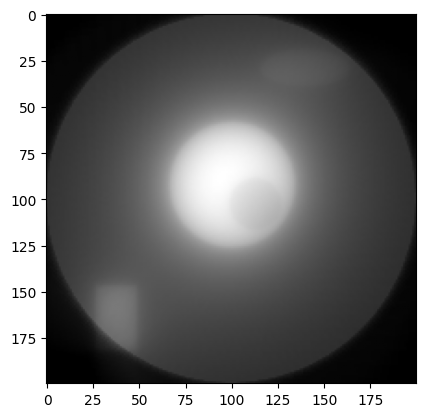

In [17]:
plt.imshow(bp, cmap ="gray")

Can you see our original image here? It is a bit blurry, but this is exactly what happens with the actual CT images reconstructed through backprojection. Next step, to get a nice and crisp image out of it would be running image through a sharpening filter and obtaining what radiologists usually see at their workstation - a _filtered backprojection_.

There are many ways to construct that filter, and sometimes you will see in the CT imaging datasets (to which we will get later in the course) various metdata items referring to convolutions - these parameters have to do with varoius scanner settings available to the operator, which control the filters applied to unfiltered backprojections.

In [ ]:
# TASK: There is a slice of a brain CT in the same directory as our phantom.bmp, named sample_brain.png. 
# Similar to what was done above, simulate a set of parallel-beam projections at every 1 degree, plot a sinogram, 
# and plot an unfiltered backprojection


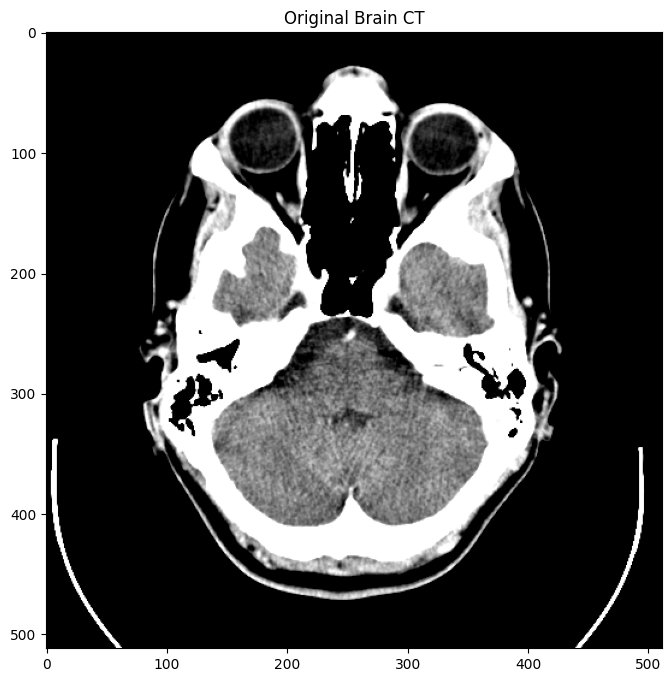

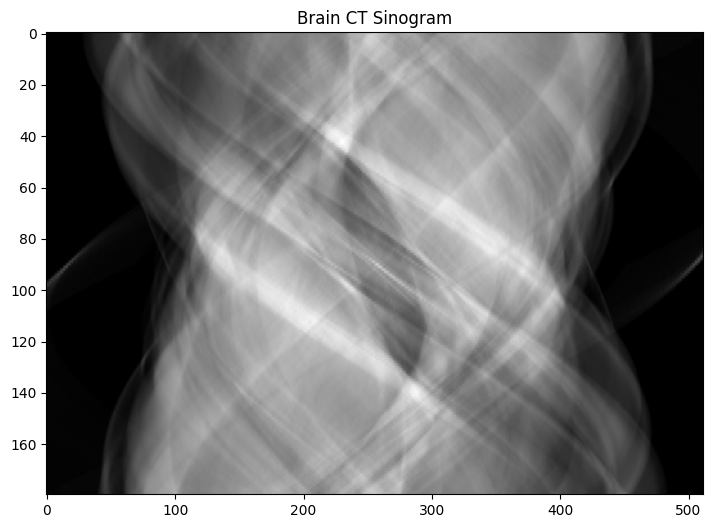

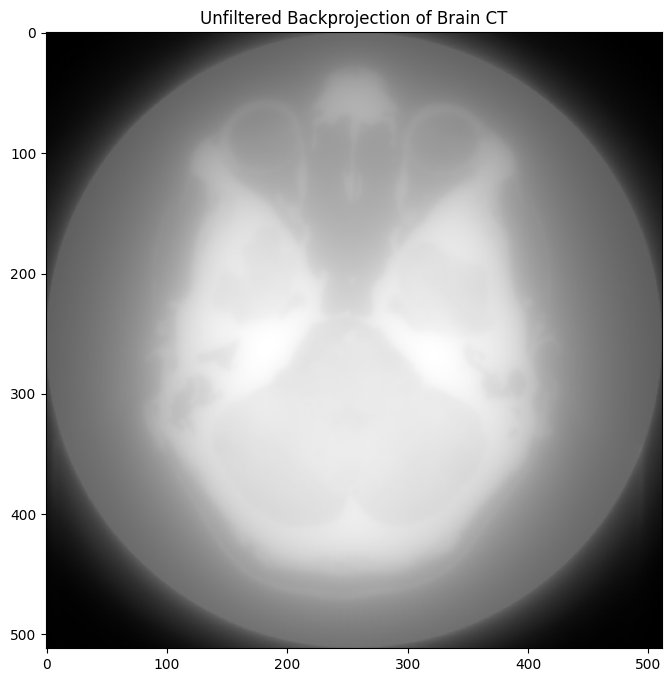

In [18]:
## <YOUR CODE>
# Load the brain CT image
brain = Image.open("sample_brain.png").convert("L")

# Display original image
plt.figure(figsize=(8, 8))
plt.imshow(brain, cmap="gray")
plt.title("Original Brain CT")
plt.show()

# Compute projections at 1-degree intervals
brain_projections = []
for angle in range(0, 180, 1):
    p = []
    brain_r = brain.rotate(angle)
    for x in range(0, brain.width):
        p.append(np.sum(np.array(brain_r)[x]))
    brain_projections.append((angle, p))

# Create and display sinogram
brain_sinogram = np.stack([p[1] for p in brain_projections])
plt.figure(figsize=(10, 6))
plt.imshow(brain_sinogram, cmap="gray", aspect=2)
plt.title("Brain CT Sinogram")
plt.show()

# Perform backprojection
bp_brain = np.zeros((brain.width, brain.height))

for p in brain_projections:
    # Smear the projection
    img = np.zeros(bp_brain.shape)
    for y in range(img.shape[1]):
        img[:, y] = p[1]
    
    # Rotate the projection back
    img = nd.rotate(img, -p[0], reshape=False)
    
    bp_brain += img

# Display reconstructed image
plt.figure(figsize=(8, 8))
plt.imshow(bp_brain, cmap="gray")
plt.title("Unfiltered Backprojection of Brain CT")
plt.show()

## Conclusion

We have gone through the basic process of obtaining a sinogram from detector signal, and reconstructing an image using a process called _backprojection_. You have seen that the image that is obtained after this process is not yet quite crisp, and additional filtering pass is required. 

Note that there are a few differences between the simulated process here and how actual CT scans are obtained. We will cover those in a video that follows.

If you want to dig deeper into sinograms and backprojections, here's a cool simulator of CT scanner operation: http://xrayphysics.com/ctsim.html

# Explanation of the CT Reconstruction Notebook

This notebook demonstrates the basic principles of computed tomography (CT) image reconstruction using a simulated phantom image and a real brain CT slice. It uses PIL for image loading and manipulation, matplotlib for visualization, numpy for numerical operations, and scipy.ndimage for image rotation. The workflow begins by loading and displaying a phantom image, then simulates X-ray projections by summing pixel values along columns. The image is rotated to simulate scanner movement, and projections are computed at multiple angles to build a sinogram—a 2D array representing all projections. Backprojection is performed by smearing each projection across an image, rotating it back, and summing the results to reconstruct the original image, which is visualized as a blurry version of the phantom. The same process is applied to a real brain CT image, demonstrating the creation of a sinogram and unfiltered backprojection. Key concepts illustrated include projection, sinogram, backprojection, and the need for filtering to obtain sharp images. This hands-on demonstration helps visualize the mathematics and physics behind CT imaging.

---

## 1. **Packages Used**

- **PIL (Python Imaging Library)**: For loading and manipulating images.
- **matplotlib.pyplot**: For plotting and visualizing images and data.
- **numpy**: For numerical operations and array manipulations.
- **scipy.ndimage**: For image processing, specifically rotating arrays.

---

## 2. **Workflow Steps**

### **A. Loading and Visualizing the Phantom Image**

- The phantom image (`phantom.bmp`) is loaded in grayscale using PIL.
- The image is displayed using `plt.imshow()` to visualize the synthetic phantom.

### **B. Computing a Single Projection**

- The image is converted to a NumPy array.
- For each column (simulating a parallel X-ray beam), the pixel values are summed, representing the total attenuation along that path.
- The resulting 1D projection is plotted, showing the "X-ray" profile.

### **C. Rotating and Projecting Again**

- The image is rotated (e.g., by 60°) to simulate the scanner's rotation.
- The projection process is repeated for the rotated image, and the new projection is plotted.

### **D. Building the Sinogram**

- The image is rotated in small increments (e.g., every 3° from 0° to 180°).
- For each angle, a projection is computed and stored.
- All projections are stacked to form a 2D array called a **sinogram**, which is visualized as an image. The sinogram represents all the raw data collected by the scanner.

### **E. Backprojection (Image Reconstruction)**

- For each projection:
    - The 1D projection is "smeared" across a blank image (all columns get the same value for each row).
    - The smeared image is rotated back by the negative of the original projection angle.
    - All rotated images are summed to form the reconstructed image.
- The result is displayed, showing a blurry version of the original phantom.

### **F. Applying the Process to a Real Brain CT Image**

- The same steps are repeated for a real brain CT image (`sample_brain.png`):
    - Load and display the image.
    - Compute projections at every 1°.
    - Stack projections to form a sinogram and display it.
    - Perform unfiltered backprojection and display the reconstructed image.

---

## 3. **Key Concepts Illustrated**

- **Projection**: Summing pixel values along a direction simulates the X-ray attenuation measurement.
- **Sinogram**: A collection of projections at different angles; the raw data for CT reconstruction.
- **Backprojection**: The process of reconstructing the original image by "smearing" each projection back over the image at the corresponding angle and summing the results.
- **Blurring**: Unfiltered backprojection results in a blurry image; real CT uses additional filtering (filtered backprojection) for sharper images.

---

## 4. **Summary**

This notebook provides a hands-on demonstration of how CT scanners collect projection data and reconstruct images using backprojection. It uses basic image processing and plotting tools to simulate the process, helping to visualize the mathematics and physics behind CT imaging.